In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from typing import Any
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from typing import List
import torch.nn.functional as F
from typing import Tuple
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from typing import Optional
from tqdm.notebook import tqdm, trange
from minari import EpisodeData, MinariDataset
import minari
from gymnasium import Env

In [2]:
def get_space_dim(space):
    if isinstance(space, spaces.Discrete):
        return 1
    elif isinstance(space, spaces.Box):
        return space.shape[0]
    elif isinstance(space, spaces.Dict):
        return sum([get_space_dim(v) for v in space.values()])
    else:
        raise ValueError("Unsupported observation space")


m_dataset = minari.load_dataset("D4RL/pointmaze/medium-v2", True)
env = m_dataset.recover_environment().unwrapped
# Environment parameters
observation_dim = get_space_dim(env.observation_space)
action_dim = get_space_dim(env.action_space)
reward_dim = 1
value_dim = 1
transition_dim = observation_dim + action_dim + reward_dim + value_dim

print(f"Observation dim: {observation_dim}, Action dim: {action_dim}")
print(f"Reward dim: {reward_dim}, Value dim: {value_dim}")
print(f"Transition dim: {transition_dim}")

# Model parameters
n_transitions = 10
seq_len = n_transitions * transition_dim
vocab_size = 100
max_bins = vocab_size
discount_factor = 0.99
embedding_dim = 128
n_heads = 4
n_blocks = 4
n_epochs = 25
batch_size = 256
lr = 0.0006
eval_every = 2

# other parameters
n_episodes: Optional[int] = None

if n_episodes:
    m_dataset = m_dataset.sample_episodes(n_episodes)

device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

Observation dim: 8, Action dim: 2
Reward dim: 1, Value dim: 1
Transition dim: 12


In [3]:
class KBinsDiscretizer:
    def __init__(self, dataset: np.ndarray, n_bins: int, strategy: str = "ordinal"):
        self.n_bins = n_bins
        self.strategy = strategy

        # bin_edges shape: (n_features, n_bins + 1)
        self.bin_edges = self._find_bin_edges(dataset)

        self.bin_centers = (self.bin_edges[:, :-1] + self.bin_edges[:, 1:]) * 0.5
        self.bin_centers_torch = torch.from_numpy(self.bin_centers).float()

    def _find_bin_edges(self, dataset: np.ndarray):
        bin_edges = []
        if self.strategy == "uniform":
            mins, maxs = np.min(dataset, axis=0), np.max(dataset, axis=0)
            bin_edges = np.linspace(mins, maxs, self.n_bins + 1).T
        elif self.strategy == "quantile":
            quantiles = np.linspace(0, 100, self.n_bins + 1)
            bin_edges = np.percentile(dataset, quantiles, axis=0).T
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")
        return bin_edges

    def encode(
        self, X: np.ndarray, subslice: Optional[Tuple[int, int]] = None
    ) -> np.ndarray:
        if X.ndim == 1:
            # this is to handle the case where we have a single sample
            X = X[None]
        # data shape: (n_samples, n_features)
        edges = self.bin_edges
        if subslice is not None:
            start, end = subslice
            edges = edges[start:end]

        Xt = np.zeros(X.shape, dtype=np.long)

        # See documentation of numpy.isclose for an explanation of ``rtol`` and ``atol``.
        rtol = 1.0e-5
        atol = 1.0e-8

        for jj in range(X.shape[1]):
            # Values which are close to a bin edge are susceptible to numeric
            # instability. Add eps to X so these values are binned correctly
            # with respect to their decimal truncation.
            eps = atol + rtol * np.abs(X[:, jj])
            # why [1:]? bins = edges - 1, but its unclear why we leave out the first element and not the last
            Xt[:, jj] = np.digitize(X[:, jj] + eps, edges[jj][1:])

        np.clip(Xt, 0, self.n_bins - 1, out=Xt)

        return Xt

    def decode(
        self, Xt: np.ndarray, subslice: Optional[Tuple[int, int]] = None
    ) -> np.ndarray:
        if Xt.ndim == 1:
            # this is to handle the case where we have a single sample
            Xt = Xt[None]
        # data shape: (n_samples, n_features)
        centers = self.bin_centers
        if subslice is not None:
            start, end = subslice
            centers = centers[start:end]

        X = np.zeros(Xt.shape, dtype=np.float64)
        for jj in range(Xt.shape[1]):
            X[:, jj] = centers[jj, np.int_(Xt[:, jj])]

        return X

    def expectation(
        self, probs: np.ndarray, subslice: Optional[Tuple[int, int]] = None
    ) -> np.ndarray:
        if probs.ndim == 1:
            # this is to handle the case where we have a single sample
            probs = probs[None]
        # probs shape: (batch_size, n_features, n_bins)
        # bin_centers shape: (n_features, n_bins) -> (1, n_features, n_bins)
        if torch.is_tensor(probs):
            bin_centers = self.bin_centers_torch.unsqueeze(0)
        else:
            # bin_centers shape: (n_features, n_bins) -> (1, n_features, n_bins)
            bin_centers = self.bin_centers[None]

        if subslice is not None:
            start, end = subslice
            bin_centers = bin_centers[:, start:end]

        # (batch_size, n_features, n_bins) * (1, n_features, n_bins) -> sum (batch_size, n_features, n_bins) -> (batch_size, n_features)
        X = (probs * bin_centers).sum(axis=-1)
        return X

    def to(self, device):
        self.bin_centers_torch = self.bin_centers_torch.to(device)

In [4]:
# Test array
test_arr = np.array([[1, 2], [3, 4], [5, 6]])

# Initialize the discretizer
discretizer = KBinsDiscretizer(test_arr, 1000, strategy="uniform")

# Encode and decode the test array
encoded = discretizer.encode(test_arr)
decoded = discretizer.decode(encoded)

# Check if the decoded array is close to the original array
assert np.isclose(
    decoded, test_arr, atol=1e-2
).all(), f"Decoded array {decoded} is not close to the original array {test_arr}"

# Generate random probabilities
probs = F.softmax(torch.from_numpy(np.random.rand(3, 2, 1000)), dim=-1).numpy()

# Calculate the expectation
expectation = discretizer.expectation(probs)

# Check if the expectation is close to the mean of the test array
expected_mean = np.tile(np.mean(test_arr, axis=0), (3, 1))
assert np.isclose(
    expectation, expected_mean, atol=1e-1
).all(), f"Expectation {expectation} is not close to the expected mean {expected_mean}"

print("All tests passed successfully.")

All tests passed successfully.


In [5]:
def flatten_space(s_dict: Any, space: spaces.Space) -> np.ndarray:
    if isinstance(space, spaces.Discrete):
        return s_dict
    elif isinstance(space, spaces.Box):
        return s_dict
    elif isinstance(space, spaces.Dict):
        return np.concatenate([s_dict[k] for k in space.spaces.keys()], axis=-1)
    else:
        raise ValueError("Unsupported observation space")


def unflatten_space(s_flat: np.ndarray, space: spaces.Space) -> dict:
    if isinstance(space, spaces.Discrete):
        return s_flat
    elif isinstance(space, spaces.Box):
        return s_flat
    elif isinstance(space, spaces.Dict):
        s_dict = {}
        start = 0
        for k, v in space.spaces.items():
            end = start + get_space_dim(v)
            s_dict[k] = s_flat[:, start:end]
            start = end
        return s_dict
    else:
        raise ValueError("Unsupported observation space")


# Test the flatten_space_dict and unflatten_space_dict functions
test_dict = {"obs": np.array([[1, 2, 3], [4, 5, 6]]), "act": np.array([[0], [1]])}
test_space = spaces.Dict(
    {"obs": spaces.Box(low=0, high=10, shape=(3,)), "act": spaces.Discrete(2)}
)
test_flat = flatten_space(test_dict, test_space)
test_unflat = unflatten_space(test_flat, test_space)

assert np.isclose(
    test_flat, np.array([[0, 1, 2, 3], [1, 4, 5, 6]])
).all(), f"Flattened array {test_flat} is not as expected."
assert np.isclose(
    test_unflat["obs"], test_dict["obs"]
).all(), f"Unflattened observation {test_unflat['obs']} is not as expected."
assert np.isclose(
    test_unflat["act"], test_dict["act"]
).all(), f"Unflattened action {test_unflat['act']} is not as expected."

# test discrete space
test_dict = np.array([[0], [1]])
test_space = spaces.Discrete(2)
test_flat = flatten_space(test_dict, test_space)
test_unflat = unflatten_space(test_flat, test_space)

assert np.isclose(
    test_flat, test_dict
).all(), f"Flattened array {test_flat} is not as expected."
assert np.isclose(
    test_unflat, test_dict
).all(), f"Unflattened array {test_unflat} is not as expected."

# test box space
test_dict = np.array([[1, 2, 3], [4, 5, 6]])
test_space = spaces.Box(low=0, high=10, shape=(3,))
test_flat = flatten_space(test_dict, test_space)
test_unflat = unflatten_space(test_flat, test_space)

assert np.isclose(
    test_flat, test_dict
).all(), f"Flattened array {test_flat} is not as expected."
assert np.isclose(
    test_unflat, test_dict
).all(), f"Unflattened array {test_unflat} is not as expected."

print("All tests passed successfully.")

All tests passed successfully.


In [6]:
def join_trajectory(env: Env, episode: EpisodeData, discount: float = 0.99):
    trajectory_len = episode.rewards.shape[0]
    observations = episode.observations
    actions = episode.actions
    rewards = episode.rewards

    values = np.zeros(trajectory_len)
    # calculate rewards to go with discount
    for i in range(trajectory_len - 1, -1, -1):
        values[i] = rewards[i] + (
            discount * values[i + 1] if i + 1 < trajectory_len else 0
        )

    # drop the last state because we don't have a reward for it
    states = flatten_space(observations, env.observation_space)
    states = states[:-1, :].reshape(trajectory_len, -1)
    actions = actions.reshape(trajectory_len, -1)
    rewards = rewards.reshape(trajectory_len, -1)
    values = values.reshape(trajectory_len, -1)

    joined = np.concatenate([states, actions, rewards, values], axis=-1)

    return joined


class DiscretizeDataset(Dataset):
    # Each input into the sequence model needs to be (batch_size, tokens)
    # output should be in groups of transitions
    def __init__(
        self,
        env: Env,
        m_dataset: MinariDataset,
        n_transitions: int,
        discount: float = 0.99,
        max_bins: int = 1000,
    ):
        self.m_dataset = m_dataset
        self.n_transitions = n_transitions

        self.joined_trajectories = []
        for episode in m_dataset:
            self.joined_trajectories.append(join_trajectory(env, episode, discount))

        self.discretizer = KBinsDiscretizer(
            n_bins=max_bins,
            strategy="quantile",
            dataset=np.concatenate(self.joined_trajectories, axis=0),
        )

        indices = []
        for traj_idx, joined_trajectory in enumerate(self.joined_trajectories):
            traj_len = joined_trajectory.shape[0]
            end = traj_len - 1
            for i in range(end):
                indices.append((traj_idx, i, i + n_transitions))

        self.indices = np.array(indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        traj_idx, start, end = self.indices[idx]
        # shape (start - end)
        joined = self.joined_trajectories[traj_idx][start:end]
        loss_pad_mask = np.ones(
            (self.n_transitions, joined.shape[-1]), dtype=np.float32
        )
        if joined.shape[0] < self.n_transitions:
            joined = np.pad(
                joined,
                ((0, self.n_transitions - joined.shape[0]), (0, 0)),
                mode="constant",
                constant_values=0,
            )
            loss_pad_mask[joined.shape[0] :] = 0

        joined_discretized = self.discretizer.encode(joined)
        joined_discretized = joined_discretized.reshape(-1).astype(np.long)
        loss_pad_mask = loss_pad_mask.reshape(-1)
        return joined_discretized[:-1], joined_discretized[1:], loss_pad_mask[:-1]

In [7]:
dataset = DiscretizeDataset(
    env=env,
    m_dataset=m_dataset,
    n_transitions=n_transitions,
    discount=discount_factor,
    max_bins=max_bins,
)

print(f"Length of dataset: {len(dataset)}")
print(f"Shape of dataset: {dataset[0][0].shape}, {dataset[0][1].shape}")

Length of dataset: 995248
Shape of dataset: (119,), (119,)


In [9]:
class Block(nn.Module):
    def __init__(self, seq_len, embedding_dim: int, n_heads: int):
        super().__init__()
        self.attn = nn.MultiheadAttention(embedding_dim, n_heads, batch_first=True)
        self.attn_norm = nn.LayerNorm(embedding_dim)

        self.fc1 = nn.Linear(embedding_dim, embedding_dim * 2)
        self.fc2 = nn.Linear(embedding_dim * 2, embedding_dim)
        self.fc_norm = nn.LayerNorm(embedding_dim)

        # mask value of true means that the value is not allowed to be attended to
        self.register_buffer("mask", ~torch.tril(torch.ones(seq_len, seq_len)).bool())
        # transition_dim - 1 stores rewards to go, we don't want to attend to them because they contain future information
        self.mask[:, transition_dim - 1 :: transition_dim] = True

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape (batch_size, n_tokens, embedding_dim)
        _, n_tokens, _ = x.shape
        # attn_mask shape (seq_len, seq_len), but incoming shape is (batch_size, n_tokens, embedding_dim)
        # so filter the mask to the correct size (n_tokens, n_tokens)
        attn_mask = self.mask[:n_tokens, :n_tokens]
        # attn_output shape (batch_size, n_tokens, embedding_dim)
        attn_output, _ = self.attn(x, x, x, attn_mask=attn_mask)
        # add and norm
        # attn_output shape (batch_size, n_tokens, embedding_dim)
        attn_output = self.attn_norm(attn_output + x)

        # fc_output shape (batch_size, n_tokens, embedding_dim)
        fc_output = self.fc1(attn_output)
        fc_output = torch.relu(fc_output)
        fc_output = self.fc2(fc_output)
        fc_output = self.fc_norm(fc_output + attn_output)

        return fc_output


class TrajectoryTransformer(nn.Module):
    def __init__(
        self,
        seq_len: int,
        embedding_dim: int,
        n_heads: int,
        transition_dim: int,
        n_blocks: int,
        vocab_size: int,
    ):
        super().__init__()
        self.seq_len = seq_len
        self.embedding_dim = embedding_dim
        self.n_heads = n_heads
        self.transition_dim = transition_dim
        self.n_blocks = n_blocks
        self.vocab_size = vocab_size

        self.token_embedding = nn.Embedding(seq_len * vocab_size, self.embedding_dim)
        self.positional_embedding = nn.Parameter(
            torch.zeros(1, seq_len, self.embedding_dim)
        )

        self.blocks = nn.ModuleList(
            [
                Block(self.seq_len, self.embedding_dim, self.n_heads)
                for _ in range(self.n_blocks)
            ]
        )

        self.fc = nn.Linear(self.embedding_dim, vocab_size)

    def get_seq_len(self):
        return self.seq_len

    def _offset_tokens(self, tokens: torch.Tensor) -> torch.Tensor:
        _, n_tokens = tokens.shape
        n_transition = np.ceil(n_tokens / self.transition_dim).astype(int)

        offsets = (
            torch.arange(self.transition_dim, device=tokens.device) * self.vocab_size
        )
        # repeat the offset n_transition times
        offsets = offsets.repeat(n_transition)
        offset_idx = offsets[:n_tokens] + tokens
        return offset_idx

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        # tokens shape (batch_size, n_tokens)
        _, n_tokens = tokens.shape
        assert (
            n_tokens <= self.seq_len
        ), f"n_tokens {n_tokens} is greater than seq_len {self.seq_len}"

        # project each token into their vocab space, this is similar to tokenization
        # (batch_size, n_tokens)
        offset_idx = self._offset_tokens(tokens)

        # (batch_size, n_tokens, embedding_dim)
        tokens = self.token_embedding(offset_idx)
        positional_embedding = self.positional_embedding[:, :n_tokens]
        tokens += positional_embedding

        for block in self.blocks:
            tokens = block(tokens)
        # (batch_size, n_tokens, embedding_dim) -> (batch_size, n_tokens, vocab_size)
        logits = self.fc(tokens)
        return logits

In [36]:
def sample_token_from_logits(
    logits: torch.Tensor,
    temperature: float = 1.0,
    greedy: bool = False,
    top_k: Optional[int] = None,
) -> torch.Tensor:
    """
    Sample the next token from the logits using temperature scaling and top-k sampling.

    Args:
        logits (torch.Tensor): The model's predicted logits.
        temperature (float): The temperature scaling factor.
        greedy (bool): Whether to sample greedily.
        top_k (Optional[int]): The top-k sampling parameter.

    Returns:
        torch.Tensor: The sampled token.
    """
    # Apply temperature scaling
    if temperature != 1.0:
        logits = logits / temperature

    # Apply top-k sampling
    if top_k is not None:
        # Apply top-k sampling
        # (batch_size, vocab_size) -> (batch_size, top_k)
        v, indices = torch.topk(logits, top_k, dim=-1)
        # set all logits to -inf except the top-k indices
        logits[logits < v[:, [-1]]] = -float("Inf")
        probs = F.softmax(logits, dim=-1)
        # Sample from the top-k indices
        # (batch_size, top_k) -> (batch_size, 1)
        idx = torch.multinomial(probs, num_samples=1)
    else:
        # Sample from the logits
        probs = F.softmax(logits, dim=-1)
        if not greedy:
            idx = torch.multinomial(probs, num_samples=1)
        else:
            # Greedy sampling
            _, idx = torch.max(probs, dim=-1)
    return idx


def round_to_multiple(number, multiple):
    pad = (multiple - number % multiple) % multiple
    return number + pad


def sample_tokens(
    model: nn.Module,
    context: nn.Module,
    n_steps: int,
    temperature: float = 1.0,
    greedy: bool = False,
    top_k: Optional[int] = None,
) -> torch.Tensor:
    """
    Sample a sequence of tokens from the model.

    Args:
        model (nn.Module): The model to sample from.
        context (nn.Module): The context to condition the sampling on.
        n_steps (int): The number of steps to sample.
        temperature (float): The temperature scaling factor.
        greedy (bool): Whether to sample greedily.
        top_k (Optional[int]): The top-k sampling parameter.

    Returns:
        torch.Tensor: The sampled tokens.
    """
    raw_logits = torch.zeros(
        context.shape[0], n_steps, vocab_size, device=context.device
    )
    for i in range(n_steps):
        # crop the context so that it doesn't exceed the seq_len
        curr_context_len = context.shape[1]
        n_crop = round_to_multiple(
            max(0, curr_context_len - model.get_seq_len()), transition_dim
        )
        context = context[:, n_crop:]
        # Get the model's prediction
        # (batch_size, seq_len, vocab_size)
        logits = model(context)
        # Sample the next token
        # (batch_size, 1)
        token = sample_token_from_logits(
            logits[:, -1], temperature=temperature, greedy=greedy, top_k=top_k
        )

        context = torch.cat([context, token], dim=-1)

        raw_logits[:, i] = logits[:, -1]
    return context, raw_logits


def beam_plan(
    model: nn.Module,
    discretizer: KBinsDiscretizer,
    context: torch.Tensor,
    beam_width: int,
    beam_steps: int,
    beam_context: int,
    sample_expansion: int,
    observation_dim: int,
    action_dim: int,
    reward_dim: int,
    value_dim: int,
    transition_dim: int,
    obs_top_k: Optional[int] = None,
    act_top_k: Optional[int] = None,
    rew_top_k: Optional[int] = None,
    temperature: float = 1.0,
    greedy: bool = False,
) -> torch.Tensor:
    tokens_context_size = beam_context * transition_dim
    n_crop = round_to_multiple(
        max(0, context.shape[1] - tokens_context_size), transition_dim
    )
    context = context[:, n_crop:]
    # context shape (seq_len) -> (beam_width, seq_len)
    plan = context.repeat(beam_width, 1)

    rewards = torch.zeros(beam_width, beam_steps + 1, device=context.device)
    discounts = discount_factor ** torch.arange(beam_steps + 1, device=context.device)

    for t in trange(beam_steps, desc="Beam Search", leave=False):
        # (beam_width, n_tokens) -> (beam_width * sample_expansion, n_tokens)
        plan = plan.repeat(sample_expansion, 1)
        rewards = rewards.repeat(sample_expansion, 1)

        # sample actions
        plan, _ = sample_tokens(
            model,
            plan,
            n_steps=action_dim,
            top_k=act_top_k,
            temperature=temperature,
            greedy=greedy,
        )

        # sample rewards and values
        # plan (beam_width * sample_expansion, n_tokens) -> (beam_width * sample_expansion, n_tokens + reward_dim + value_dim)
        # logits shape (beam_width * sample_expansion, reward_dim + value_dim, vocab_size)
        plan, logits = sample_tokens(
            model,
            plan,
            n_steps=reward_dim + value_dim,
            top_k=rew_top_k,
            temperature=temperature,
            greedy=greedy,
        )

        probs = F.softmax(logits, dim=-1)
        rewards_and_values = discretizer.expectation(
            probs, subslice=(transition_dim - 2, transition_dim)
        )

        rewards[:, t : t + 2] = rewards_and_values
        # Did you notice that rewards contains rewards at t and values at t+1, why?
        #   when we want to calculate value (rewards to go) at t, we need to consider discounted rewards from 0 to t
        #   and also future discounted rewards from t+1 to end. It is a bit awkward to apply discount factor to value (at t+1)
        #   because predicted value is already discounted.
        # (beam_width * sample_expansion, beam_steps + 1) * (beam_steps + 1) -> (beam_width * sample_expansion)
        values = (rewards * discounts).sum(dim=-1)

        # select top-k sequences
        # (beam_width * sample_expansion) -> (beam_width)
        values, idx = torch.topk(values, beam_width)

        plan, rewards = plan[idx], rewards[idx]

        if t < beam_steps - 1:
            # sample observations only if we are not at the last step, why?
            # because beam plan has to end with a valid transition [...., obs, act, rew, val]
            plan, _ = sample_tokens(
                model,
                plan,
                n_steps=observation_dim,
                top_k=obs_top_k,
                temperature=temperature,
                greedy=greedy,
            )

    best_idx = torch.argmax(values)
    # only return the best plan without the context
    best_plan = plan[best_idx, context.shape[1] :]

    return best_plan


def rollout(
    model: nn.Module,
    env: Env,
    discretizer: KBinsDiscretizer,
    beam_width: int,
    beam_steps: int,
    beam_context: int,
    sample_expansion: int,
    observation_dim: int,
    action_dim: int,
    reward_dim: int,
    value_dim: int,
    transition_dim: int,
    max_steps: int,
    plan_every: int,
    obs_top_k: Optional[int] = None,
    act_top_k: Optional[int] = None,
    rew_top_k: Optional[int] = None,
    temperature: float = 1.0,
    greedy: bool = False,
    device: torch.device = torch.device("cpu"),
    generate_gif: bool = False,
):
    trajectory = []
    assert (
        plan_every <= beam_steps
    ), f"plan_every {plan_every} should be less than or equal to beam_steps {beam_steps}"
    obs, _ = env.reset()
    imgs = []
    if generate_gif:
        imgs.append(env.render())
    obs = flatten_space(obs, env.observation_space)
    done = False
    total_reward = 0

    context = torch.zeros(
        (1, (max_steps + 1) * transition_dim), device=device, dtype=torch.long
    )

    context_idx = 0

    # discretize the observation
    obs_token = discretizer.encode(
        np.array([obs]), subslice=(0, observation_dim)
    ).squeeze()

    context[:, :observation_dim] = torch.tensor(obs_token, device=device)

    for t in trange(max_steps, desc="Rollout", leave=False):
        if t % plan_every == 0:
            # we need to plan a new trajectory, reset the context observation at t step
            context_idx = (
                ((t + 1) * transition_dim) - action_dim - reward_dim - value_dim
            )
            predicted_tokens = beam_plan(
                model,
                discretizer,
                context[:, :context_idx],
                beam_width,
                beam_steps,
                beam_context,
                sample_expansion,
                observation_dim,
                action_dim,
                reward_dim,
                value_dim,
                transition_dim,
                obs_top_k=obs_top_k,
                act_top_k=act_top_k,
                rew_top_k=rew_top_k,
                temperature=temperature,
                greedy=greedy,
            )
        else:
            predicted_tokens = predicted_tokens[transition_dim:]

        # get the action from the predicted tokens
        action_token = predicted_tokens[:action_dim].cpu().numpy()
        # decode the action
        action = discretizer.decode(
            action_token, subslice=(observation_dim, observation_dim + action_dim)
        ).squeeze()
        action = unflatten_space(action, env.action_space)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_obs = flatten_space(next_obs, env.observation_space)
        done = terminated or truncated

        total_reward += reward

        if generate_gif:
            imgs.append(env.render())

        if done:
            break

        # discretize the next observation
        next_obs_token = discretizer.encode(next_obs, subslice=(0, observation_dim))
        # discretize the reward and value
        reward_value_tokens = discretizer.encode(
            np.array([reward, 0]), subslice=(transition_dim - 2, transition_dim)
        )

        # update the context
        context_idx = t * transition_dim
        # add action
        context[
            :,
            context_idx + observation_dim : context_idx + observation_dim + action_dim,
        ] = torch.as_tensor(action_token, device=device)
        # add reward and value
        context[
            :, context_idx + observation_dim + action_dim : context_idx + transition_dim
        ] = torch.as_tensor(reward_value_tokens, device=device)
        # add next observation
        context[
            :,
            context_idx
            + transition_dim : context_idx
            + transition_dim
            + observation_dim,
        ] = torch.as_tensor(next_obs_token, device=device)

        trajectory.append((obs, next_obs, action, reward, done))
        obs = next_obs

    if generate_gif:
        return total_reward, trajectory, imgs
    return total_reward, trajectory, _

In [11]:
def calculate_loss(
    model: nn.Module,
    batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
    vocab_size: int,
    transition_dim: int,
    observation_dim: int,
    action_dim: int,
    reward_dim: int,
    value_dim: int,
    device: torch.device = torch.device("cpu"),
) -> torch.Tensor:
    # inputs shape (batch_size, seq_len)
    # targets shape (batch_size, seq_len)
    # loss_pad_mask shape (batch_size, seq_len)
    inputs, targets, loss_pad_mask = batch
    inputs = inputs.to(device)
    targets = targets.to(device)
    loss_pad_mask = loss_pad_mask.to(device)
    # logits shape (batch_size, seq_len, vocab_size)
    logits = model(inputs)
    # flatten the logits and targets to shape (batch_size * seq_len, vocab_size)
    logits = logits.view(-1, vocab_size)
    # flatten the targets to shape (batch_size * seq_len)
    targets = targets.view(-1)
    # loss shape (batch_size * seq_len)
    loss = F.cross_entropy(logits, targets)

    n_states = int(np.ceil(inputs.shape[1] / transition_dim))
    weights = torch.cat(
        [
            torch.ones(observation_dim, device=inputs.device),
            torch.ones(action_dim, device=inputs.device) * 5,
            torch.ones(reward_dim, device=inputs.device) * 1,
            torch.ones(value_dim, device=inputs.device) * 1,
        ]
    )
    weights = weights.repeat(n_states)[1:].repeat(inputs.shape[0], 1)
    loss = loss * weights.view(-1)
    # apply the loss pad mask to the loss because we don't want to calculate the loss for padded values
    loss = (loss * loss_pad_mask.view(-1)).mean()
    return loss


def eval(
    env: Env,
    model: nn.Module,
    discretizer: KBinsDiscretizer,
    num_episodes: int,
    beam_width: int,
    beam_steps: int,
    beam_context: int,
    sample_expansion: int,
    observation_dim: int,
    action_dim: int,
    reward_dim: int,
    value_dim: int,
    transition_dim: int,
    max_steps: int,
    plan_every: int,
    obs_top_k: Optional[int] = None,
    act_top_k: Optional[int] = None,
    rew_top_k: Optional[int] = None,
    temperature: float = 1.0,
    greedy: bool = False,
    device: torch.device = torch.device("cpu"),
):
    model.eval()

    total_rewards = []

    for _ in trange(num_episodes, desc="Evaluating episode", leave=False):
        total_reward, _ = rollout(
            model,
            env,
            discretizer,
            beam_width,
            beam_steps,
            beam_context,
            sample_expansion,
            observation_dim,
            action_dim,
            reward_dim,
            value_dim,
            transition_dim,
            max_steps,
            plan_every,
            obs_top_k=obs_top_k,
            act_top_k=act_top_k,
            rew_top_k=rew_top_k,
            temperature=temperature,
            greedy=greedy,
            device=device,
        )
        total_rewards.append(total_reward)

    mean_rewards = np.mean(total_rewards)
    std_rewards = np.std(total_rewards)

    model.train()
    return mean_rewards, std_rewards


def train(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    vocab_size: int,
    n_epochs: int,
    writer: SummaryWriter,
    device: torch.device = torch.device("cpu"),
    eval_every: int = 10,
):
    model.train()
    step = 0
    for epoch in trange(n_epochs, desc="Training"):
        total_loss = 0
        for batch in tqdm(
            dataloader, desc=f"Epoch {epoch + 1}/{n_epochs}", leave=False
        ):
            optimizer.zero_grad()
            loss = calculate_loss(
                model,
                batch,
                vocab_size,
                device=device,
                transition_dim=transition_dim,
                observation_dim=observation_dim,
                action_dim=action_dim,
                reward_dim=reward_dim,
                value_dim=value_dim,
            )
            loss.backward()
            optimizer.step()
            writer.add_scalar("Loss/train", loss.item(), step)
            total_loss += loss.item()
            step += 1


print(f"Using device: {device}")

writer = SummaryWriter()
dataset.discretizer.to(device)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = TrajectoryTransformer(
    seq_len, embedding_dim, n_heads, transition_dim, n_blocks, vocab_size
).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
train(
    model,
    dataloader,
    optimizer,
    vocab_size,
    n_epochs,
    writer,
    device=device,
    eval_every=eval_every,
)

Using device: mps


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 6/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 11/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 16/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 21/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/3888 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/3888 [00:00<?, ?it/s]

In [67]:
total_reward, trajectory, imgs = rollout(
    model=model,
    env=minari.load_dataset("D4RL/pointmaze/medium-v2", True).recover_environment(
        render_mode="rgb_array", continuing_task=False
    ),
    discretizer=dataset.discretizer,
    beam_width=4,
    beam_steps=3,
    beam_context=7,
    sample_expansion=2,
    observation_dim=observation_dim,
    action_dim=action_dim,
    reward_dim=reward_dim,
    value_dim=value_dim,
    transition_dim=transition_dim,
    max_steps=400,
    plan_every=1,
    obs_top_k=1,
    act_top_k=2,
    rew_top_k=None,
    temperature=1.0,
    greedy=False,
    device=device,
    generate_gif=True,
)
print(f"Total reward: {total_reward}")

Rollout:   0%|          | 0/400 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/3 [00:00<?, ?it/s]

Total reward: 1.0


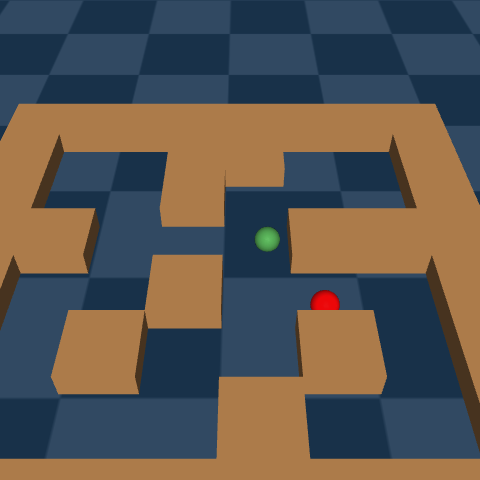

In [68]:
import imageio
from IPython.display import Image

# save the images as a gif
imageio.mimsave("trajectory.gif", imgs, fps=30)
# display the gif and repeat it forever
Image(filename="trajectory.gif")